In [1]:
# I tried to forecast household electric power using XGBoost, mainly involving creating time series features and lagging features.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings # Supress warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [2]:
df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

# Data processing

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

<AxesSubplot:>

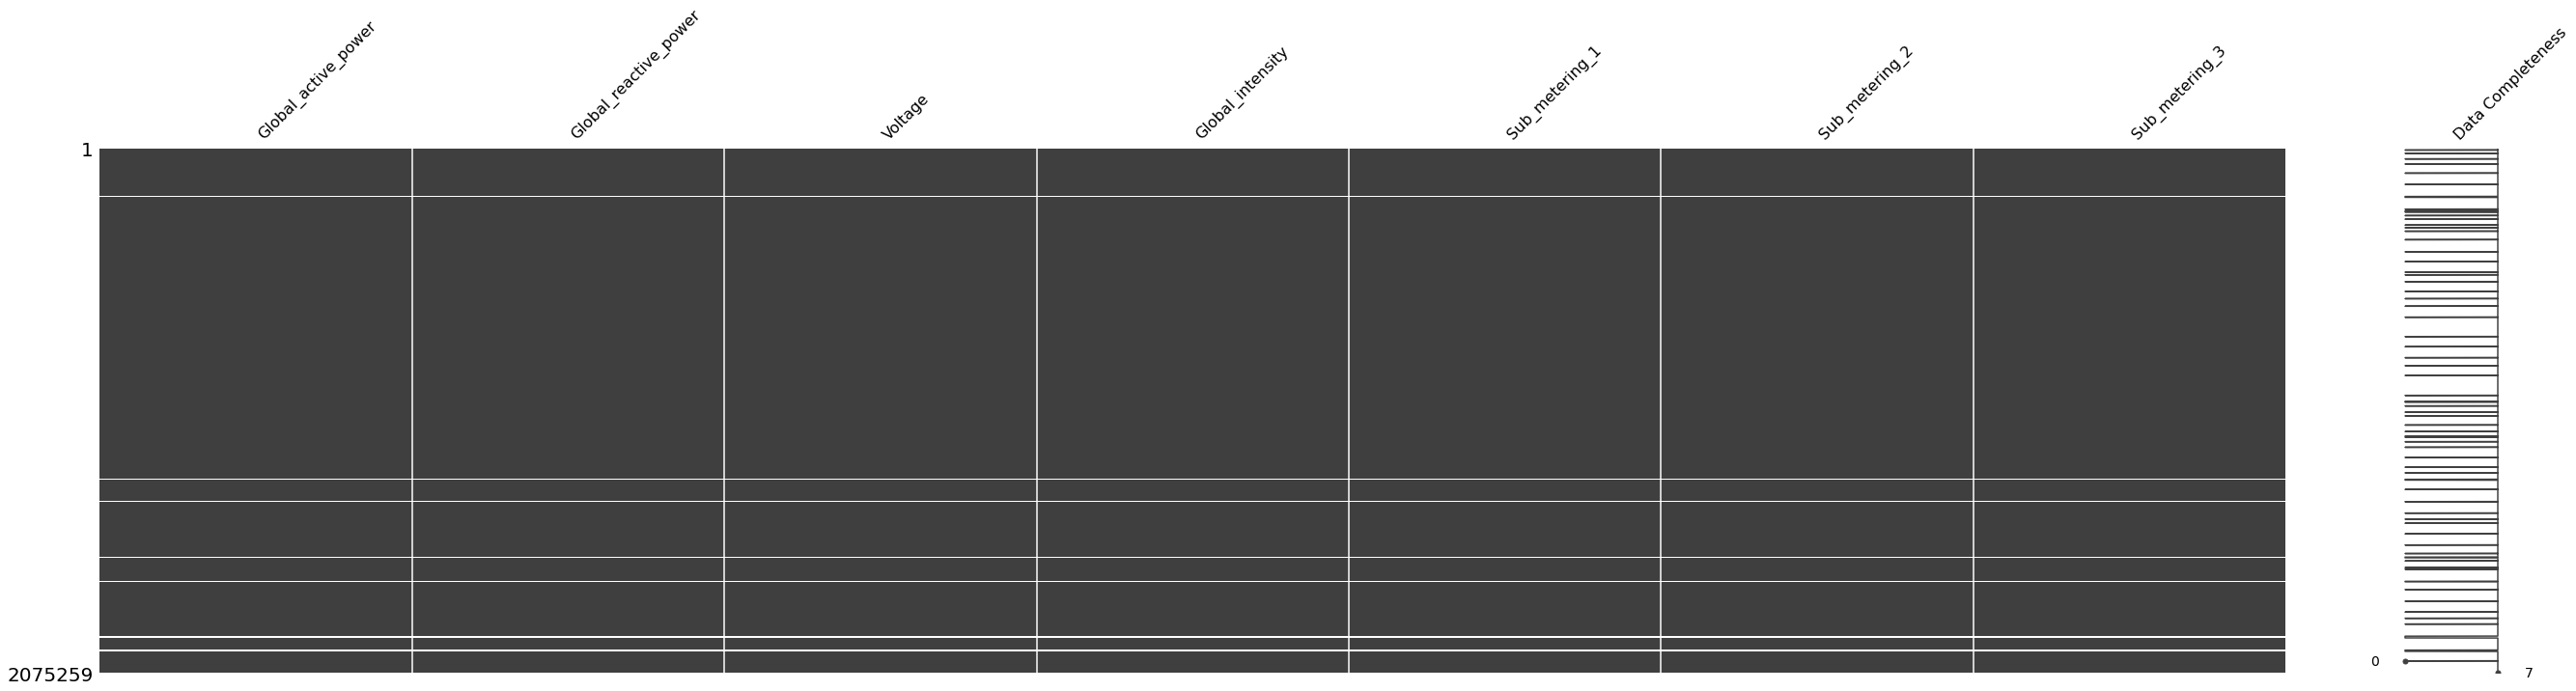

In [5]:
import missingno as msno
msno.matrix(df, labels=True,figsize=(45,10))

There are some options for dealing with with missing values 'nan'.

Option 1: Fill NaN with Outlier or Zero.

Option 2: Fill NaN with Mean Value or other values.

Option 3: Fill NaN with Last Value with .ffill()

I think filling NaNs with the last value is a little bit better in this case, because the time delta is only 1 minute.

Option 4: Fill NaN with Linearly Interpolated Value with .interpolate().

In [6]:
newdf = df.fillna(method='ffill')

In [7]:
newdf.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
newdf.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
std,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# Create Time Series Features & lagging features

Useful link: https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook

"A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation."

In [9]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col,axis=1,inplace = True)
    return data

In [10]:
# Set 15 minutes as a lagging time unit, therefore lagging time will be 15 min * n, such as 15 min, 30 min, 1 hour and so on. 
# The smaller this lagging time unit is, the better the predicting result is. 

def get_lag(data, col, lagtime):
    for i in range(1,lagtime+1):
        if len(pd.Series(col)) == 1:
            data[col+"_lag"+str(i)] = data[col].shift(i*15)
        else:
            for col_j in col:
                data[col_j+"_lag"+str(i)] = data[col_j].shift(i*15)
    return data

In [11]:
# Create Time Series Features 

newdf['date'] = newdf.index

newdf['hour'] = newdf['date'].dt.hour
newdf = encode(newdf,'hour',24)

newdf['dayofweek'] = newdf['date'].dt.dayofweek
newdf = encode(newdf,'dayofweek',7)

newdf['month'] = newdf['date'].dt.month
newdf = encode(newdf,'month',12)

# newdf['year'] = newdf['date'].dt.year

newdf['dayofyear'] = newdf['date'].dt.dayofyear
newdf = encode(newdf,'dayofyear',365)

newdf['dayofmonth'] = newdf['date'].dt.day
newdf = encode(newdf,'dayofmonth',31)

#newdf['weekofyear'] = newdf['date'].dt.weekofyear

newdf.drop('date',axis=1,inplace = True)

In [12]:
# adding lagging feature

# adding time lags of 15min,30min as features

lagtime = 2
lag_feature = ['Global_reactive_power','Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
newdf = get_lag(newdf, lag_feature, lagtime)

# adding time lags of 2 hours as features

newdf = get_lag(newdf, 'Global_active_power', 8)

newdf.drop(lag_feature,axis=1,inplace = True)

newdf.dropna(inplace=True)

In [13]:
newdf.head()

,Global_active_power,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,...,Sub_metering_2_lag2,Sub_metering_3_lag2,Global_active_power_lag1,Global_active_power_lag2,Global_active_power_lag3,Global_active_power_lag4,Global_active_power_lag5,Global_active_power_lag6,Global_active_power_lag7,Global_active_power_lag8
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-16 19:24:00,3.262,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,16.0,3.394,4.298,2.326,3.452,4.464,2.720,3.384,4.216
2006-12-16 19:25:00,3.476,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.400,4.230,2.264,4.870,3.396,3.758,3.270,5.360
2006-12-16 19:26:00,3.620,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,2.0,16.0,3.414,4.230,2.270,4.868,3.090,4.342,3.430,5.374
2006-12-16 19:27:00,3.610,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.432,3.924,2.258,4.866,3.730,4.512,3.266,5.388
2006-12-16 19:28:00,3.646,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.418,4.218,2.188,3.176,2.308,4.058,3.728,3.666


# Train/Test Data Split

In [14]:
split_date =pd.to_datetime( '2007-12-17')
df_train = newdf.loc[newdf.index <= split_date].copy()
df_train.shape

(525877, 31)

In [15]:
#df_test = pd.DataFrame(newdf.loc[newdf.index > split_date]
df_test = pd.DataFrame(newdf.loc[newdf.index > split_date][:5000])

df_test.shape

(5000, 31)

In [16]:
# The target is forecasting Global_active_power.
X_train, y_train = df_train.iloc[:,1:],df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,1:],df_test.iloc[:,0]

# XGBoost Model

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importances

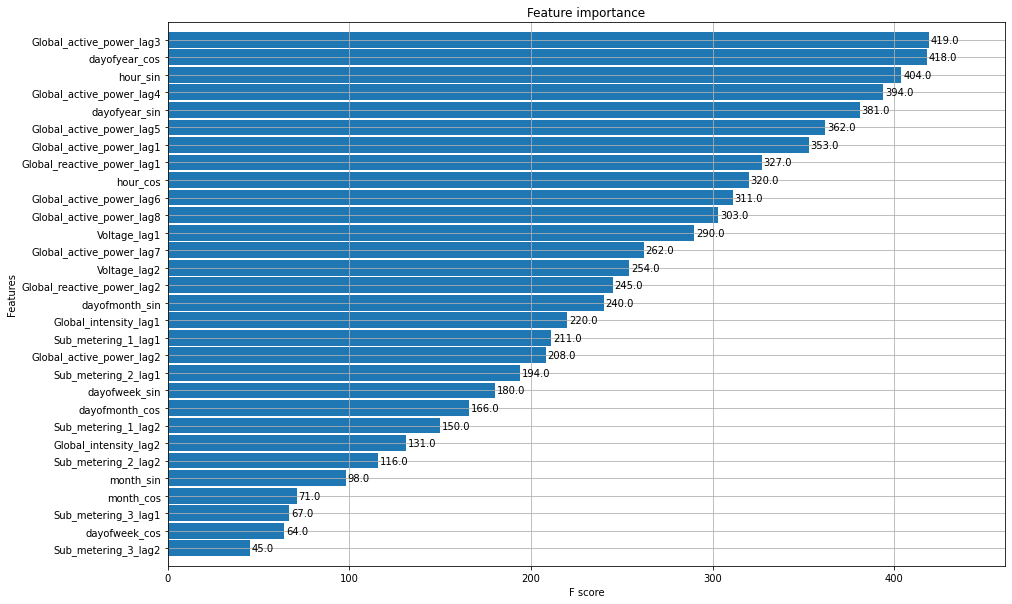

In [18]:
f, ax = plt.subplots(figsize=(15,10))
_ = plot_importance(reg, height=0.9,ax = ax)
plt.show()

# Forecast on Test Set

In [19]:
df_test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

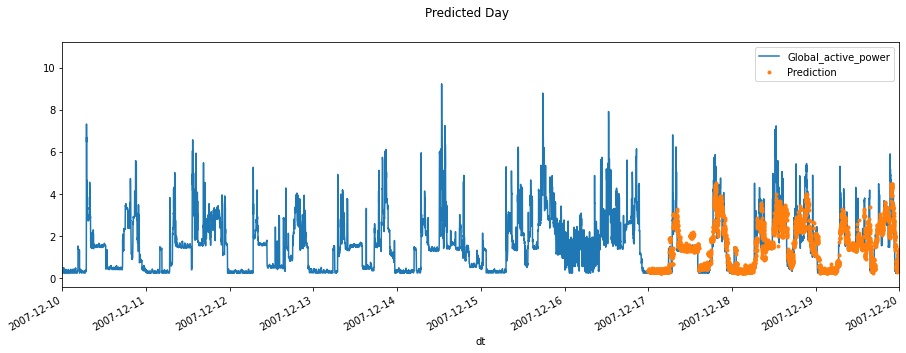

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Global_active_power','Prediction']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='12-10-2007', upper='12-20-2007')
plot = plt.suptitle('Predicted Day')
plt.show()

# RMSE On Test Set

In [21]:
np.sqrt(mean_squared_error(df_test['Prediction'], df_test['Global_active_power']))

0.6902982409967734

Useful link:

https://www.kaggle.com/code/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook

https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook

I use some codes of the notebooks above.

Thanks for giving advice.